In [1]:
import os
import json
import tqdm
import random
import shutil
import pandas as pd
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
import torchaudio
import torchaudio.transforms as T
from torchvision.models.resnet import ResNet, BasicBlock

import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


### Загрузим данные

In [3]:
root_path = "../input/birdclef-2022/"
input_path = root_path + '/train_audio/'
out_path = "./train/"

try:
    os.mkdir(out_path)
except FileExistsError:
    pass


train_meta = pd.read_csv(root_path + 'train_metadata.csv')

with open(root_path + '/scored_birds.json') as sbfile:
    scored_birds = json.load(sbfile)

In [4]:
train_meta = train_meta[train_meta['primary_label'].isin(scored_birds)]
bird_label = train_meta["primary_label"].unique()
print(bird_label)

['akiapo' 'aniani' 'apapan' 'barpet' 'crehon' 'elepai' 'ercfra' 'hawama'
 'hawcre' 'hawgoo' 'hawhaw' 'hawpet1' 'houfin' 'iiwi' 'jabwar' 'maupar'
 'omao' 'puaioh' 'skylar' 'warwhe1' 'yefcan']


### Параметры спектрограмм

In [5]:
sample_rate = 32000
n_fft = 4096
win_length = None
hop_length = 512
n_mels = 256
min_sec_proc = sample_rate*5
f_min = 1000

mel_spectrogram = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    f_min=f_min,
    pad_mode="reflect",
    power=2.0,
    norm='slaney',
    onesided=True,
    n_mels=n_mels,
    mel_scale="htk",
)

In [6]:
def torch_fix_seed(seed=34):
    # Python random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True
    
    
def normalize_std(spec):
    return (spec - torch.mean(spec)) / torch.std(spec)
    
    
def audio_to_mel_label(filepath, min_sec_proc, mode='train', data_index=0, label_list=[], bird_label=[], label_file=[], mel_list=[]):
    if mode == 'train':
        label_file_all = np.zeros(bird_label.shape)
        for label_file_temp in label_file:
            label_file_all += (label_file_temp == bird_label)
        label_file_all = np.clip(label_file_all, 0, 1)
    
    waveform, sample_rate_file = torchaudio.load(filepath=filepath)
    len_wav = waveform.shape[1]
    waveform = waveform[0,:].reshape(1, len_wav) # stereo->mono mono->mono
    if mode == 'train':
        if len_wav < min_sec_proc:
            for _ in range(round(min_sec_proc/len_wav)):
                waveform = torch.cat((waveform,waveform[:,0:len_wav]),1)
            len_wav = min_sec_proc
            waveform = waveform[:,0:len_wav]
    elif mode == 'test':
        if not len_wav < min_sec_proc*12:
            waveform = torch.cat((waveform,waveform[:,0:len_wav]),1)
            len_wav = min_sec_proc*12
            waveform = waveform[:,0:len_wav]

    for index in range(int(len_wav/min_sec_proc)):
        log_melspec = torch.log10(mel_spectrogram(waveform[0, index*min_sec_proc:index*min_sec_proc+min_sec_proc]).unsqueeze(0)+1e-10)
        log_melspec = normalize_std(log_melspec)
        if mode == 'train':
            torch.save(log_melspec, out_path + str(data_index) + '.pt')
            label_list.append(label_file_all)
            data_index += 1
        elif mode == 'test':
            mel_list.append(log_melspec)
            
    if mode == 'train':
        return data_index
    elif mode == 'test':
        return mel_list
    

def load_tensor(path, file_name):
    return torch.load(path + str(file_name) + '.pt')


def get_X_y(path, idx, label_list):
    batch_X = torch.stack([load_tensor(path, x.item()) for x in idx])
    batch_y = torch.stack([label_list[x.item()] for x in idx])
    return batch_X, batch_y

        
def plot_history(history):
    plt.figure(figsize=(10, 10)) 
    plt.plot(history[:,0], history[:,1], label='loss')
    plt.plot(history[:,0], history[:,2], label='val_loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    
    
torch_fix_seed()

### Получим мел-спектрограммы

In [7]:
data_index = 0
label_list = []
for pri_label, secon_label, f_name in zip(tqdm.notebook.tqdm(train_meta['primary_label']), train_meta['secondary_labels'],train_meta['filename']):
    data_index = audio_to_mel_label(input_path+f_name, min_sec_proc,'train', data_index, label_list, bird_label, [pri_label] + eval(secon_label))

torch.save(np.stack(label_list), out_path + 'label_list.pt')
label_list = torch.from_numpy(np.stack(label_list)).clone()

  0%|          | 0/1266 [00:00<?, ?it/s]

### Resnet

In [8]:
n_output = len(bird_label)

out_sigmoid = nn.Sigmoid()

class ResNetBird(ResNet):
    def __init__(self):
        super().__init__(BasicBlock, [3, 4, 6, 3], num_classes=n_output)

        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=1, padding=3, bias=False)

        
net = ResNetBird().to(device)

### Train_val_split

In [9]:
train_idx = np.arange(0, label_list.shape[0])

data_len = train_idx.shape[0]
train_idx, val_idx = torch.utils.data.random_split(train_idx, [int(data_len*0.8), data_len-int(data_len*0.8)])

### Обучение

Epoch [1/40], loss: 0.12389, val_loss: 0.12850
Epoch [2/40], loss: 0.09693, val_loss: 0.10357
Epoch [3/40], loss: 0.08202, val_loss: 0.07565
Epoch [4/40], loss: 0.07247, val_loss: 0.07701
Epoch [5/40], loss: 0.06463, val_loss: 0.07188
Epoch [6/40], loss: 0.05663, val_loss: 0.05737
Epoch [7/40], loss: 0.05108, val_loss: 0.05074
Epoch [8/40], loss: 0.04548, val_loss: 0.05888
Epoch [9/40], loss: 0.04088, val_loss: 0.05224
Epoch [10/40], loss: 0.03568, val_loss: 0.04664
Epoch [11/40], loss: 0.03215, val_loss: 0.05019
Epoch [12/40], loss: 0.02785, val_loss: 0.04685
Epoch [13/40], loss: 0.02463, val_loss: 0.03536
Epoch [14/40], loss: 0.02180, val_loss: 0.03953
Epoch [15/40], loss: 0.01910, val_loss: 0.03210
Epoch [16/40], loss: 0.01625, val_loss: 0.04411
Epoch [17/40], loss: 0.01378, val_loss: 0.03266
Epoch [18/40], loss: 0.01221, val_loss: 0.08376
Epoch [19/40], loss: 0.01030, val_loss: 0.03724
Epoch [20/40], loss: 0.00904, val_loss: 0.03507
Epoch [21/40], loss: 0.00879, val_loss: 0.03722
E

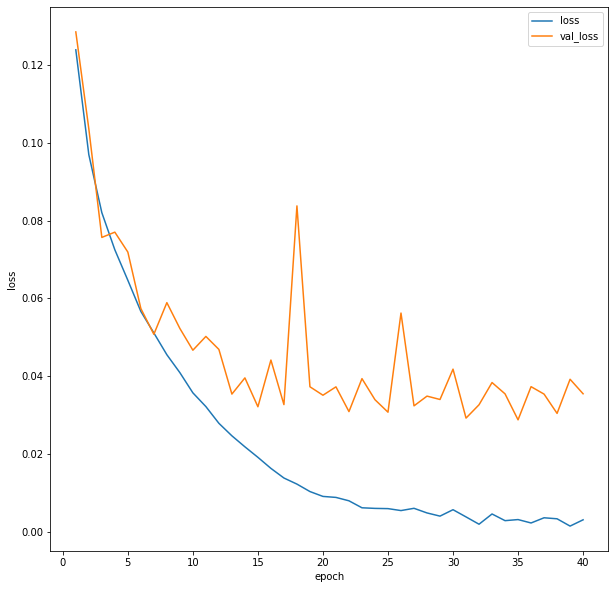

In [10]:
num_epochs = 40
lr = 0.001
batch_size = 16

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=lr)
history = np.zeros((0, 3))

train_loader = DataLoader(train_idx, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_idx, batch_size=batch_size, shuffle=False)


for epoch in range(num_epochs):
    train_loss, val_loss = 0, 0
    n_train, n_val = 0, 0

    net.train()
    for idx in train_loader:
        inputs, labels = get_X_y(out_path, idx, label_list)
        
        n_train += len(labels)
        
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    net.eval()
    with torch.no_grad():
        for idx in val_loader:
            inputs_val, labels_val = get_X_y(out_path, idx, label_list)
            n_val += len(labels)

            inputs_val = inputs_val.to(device)
            labels_val = labels_val.to(device)

            outputs_val = net(inputs_val)

            loss_val = criterion(outputs_val, labels_val)

            val_loss += loss_val.item()
    

    train_loss = train_loss * batch_size / n_train
    val_loss = val_loss * batch_size / n_val
    print (f'Epoch [{(epoch+1)}/{num_epochs}], loss: {train_loss:.5f}, val_loss: {val_loss:.5f}')
    item = np.array([epoch+1, train_loss, val_loss])
    history = np.vstack((history, item))

torch.save(net.state_dict(), 'model.pt')
plot_history(history)

### Inference

In [11]:
test_audio_dir = '../input/birdclef-2022/test_soundscapes/'
file_list = [f.split('.')[0] for f in sorted(os.listdir(test_audio_dir))]

print('Number of test soundscapes:', len(file_list))

Number of test soundscapes: 1


In [12]:
pred = {'row_id': [], 'target': []}
binary_th = 0.30
net.eval()

for afile in file_list:
    
    path = test_audio_dir + afile + '.ogg'
    
    chunks = [[] for i in range(12)]
    
    mel_list_test = []
    mel_list_test = audio_to_mel_label(path, min_sec_proc,'test', mel_list=mel_list_test)
    mel_list_test = torch.stack(mel_list_test).to(device)
    
    outputs = net(mel_list_test)
    
    outputs_test = out_sigmoid(outputs)
    
    for idx, i in enumerate(range(len(chunks))):        
        chunk_end_time = (i + 1) * 5
        for bird in scored_birds:
            
            try:
                score = outputs_test[idx][np.where(bird_label==bird)]
            except IndexError:
                score = 0
            
            row_id = afile + '_' + bird + '_' + str(chunk_end_time)
            
            pred['row_id'].append(row_id)
            pred['target'].append(True if score > binary_th else False)

### Submit

In [13]:
results = pd.DataFrame(pred, columns = ['row_id', 'target'])

print(results['target']) 
    
results.to_csv("submission.csv", index=False) 

0      False
1      False
2      False
3      False
4      False
       ...  
247    False
248    False
249     True
250    False
251    False
Name: target, Length: 252, dtype: bool


In [14]:
OUTPUT_DATA_DELETE = False

if OUTPUT_DATA_DELETE == True:
    shutil.rmtree(out_path)
    os.remove('model.pt')